# Timeseries of GPM precipitation accumulation co-located with Colorado Landslide events

## Author: Jacquelyn Witte

In [1]:
import os
from glob import glob

import earthpy as et
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr

import warnings
warnings.filterwarnings('ignore')

# Prettier plotting with seaborn
sns.set(font_scale=1.3, style="whitegrid")

#### Function to co-locate a landslide event with precipitation

In [2]:
def colocate_to_landslide(glc_df, data_xr, periods=7):
    """
    Returns a dataframe of precipitation values colocated to a landslide event.
    
    Based on the Global Landslide Catalog as input.
    Define the number of day to retrieve a precipitation value leading up
        to a landslide event.
        
    Parameters 
    ----------
    
    glc_df: pandas.core.frame.DataFrame
        The GLC dataframe
    
    data_xr: xarray.core.dataset.Dataset
        The GPM precipitation data, either single or multi day events
        
    period: int
        Number of periods to generate. Default is 7 days.

    Returns
    -------
    pandas.core.frame.DataFrame 
    """

    gpm_ts_list = []
    for i, date in enumerate(glc_df.index):
        precip = data_xr['precipitationCal'].sel(indexers={
            'time': pd.date_range(date, periods=periods, freq='-1D'),
            'lon': glc_df.longitude[i],
            'lat': glc_df.latitude[i]},
            method="nearest")
        gpm_ts_list.append(precip)
        gpm_ts_list[i]['landslideID'] = glc_df.event_id[i]


    gpm_ts_xr = xr.concat(gpm_ts_list,
                          dim='landslideID',
                          fill_value=np.nan,
                          join='override')
    
    return gpm_ts_xr.to_dataframe()

In [3]:
def add_count(df, days):
    """
    Adds a countdown column from N number of days to the Landslide event.
    
    Parameters
    ----------
    df: pandas.core.frame.DataFrame
    days: int
        Where 0 is the landslide event
    
    Returns
    -------
    pandas.core.frame.DataFrame plus added column
    """

    cnts = []
    accum = []
    ndays = np.arange(days)+1
    ndays = np.arange(start=-days, stop=0, step=1)
    for i in range(0, int(len(df['precipitationCal'])/days)): 
        cnts.extend(ndays)

    df['days-to-landslide'] = cnts
    return df

#### Change directory to where all the Capstone data reside

In [4]:
data_dir = os.path.join(et.io.HOME,
                        'earth-analytics',
                        'data')
os.chdir(data_dir)

#### Define the Global Landslide Catalog (GLC)

In [5]:
glc_file = os.path.join('capstone', 'landslide', 'nasa.glc.export.csv')
os.path.exists(glc_file) 

True

#### Read and subset to Colorado Landslides

In [6]:
# Read the GLC file
glc = pd.read_csv(glc_file)

glc_co = glc[(glc['country_code'] == 'US') & (
                                glc['admin_division_name'] == 'Colorado') & (
                                glc['landslide_trigger'] != 'freeze_thaw') &(
                            glc['landslide_trigger'] != 'snowfall_snowmelt')
            ]
# covert to datetime
glc_co['date'] = pd.to_datetime(glc_co['event_date'])
glc_co = glc_co.set_index('date').sort_index()
glc_co.head()

,source_name,source_link,event_id,event_date,event_time,event_title,event_description,location_description,location_accuracy,landslide_category,...,country_code,admin_division_name,admin_division_population,gazeteer_closest_point,gazeteer_distance,submitted_date,created_date,last_edited_date,longitude,latitude
date,,,,,,,,,,,,,,,,,,,,,
2007-06-01,Sky-Hi News,http://www.skyhidailynews.com/news/13393638-11...,6253,6/1/07 0:00,NaN,Granby landfill,"All in all, the county has spent over $7 milli...",Granby landfill,5km,landslide,...,US,Colorado,1864.0,Granby,5.53226,10/17/14 19:11,11/20/17 15:17,2/15/18 15:51,-105.8752,40.0929
2007-08-14,Telluride Daily Planet,http://www.telluridegateway.com/articles/2007/...,185,8/14/07 0:00,NaN,"Tellride, CO, Hwy 145",Tues afternoon 4pm,"Tellride, CO, Hwy 145",10km,mudslide,...,US,Colorado,2475.0,Meeker,10.87949,4/1/14 0:00,11/20/17 15:17,2/15/18 15:51,-107.8818,39.9425
2007-09-06,Craigdailypress.com,http://www.craigdailypress.com/news/2007/sep/0...,238,9/6/07 0:00,NaN,"River and Mt Warner Road, Steamboat Springs, CO","slide 75 feet down hill carrying trees, etc. o...","River and Mt Warner Road, Steamboat Springs, CO",1km,mudslide,...,US,Colorado,12088.0,Steamboat Springs,2.63588,4/1/14 0:00,11/20/17 15:17,2/15/18 15:51,-106.8295,40.4613
2007-09-17,KJCT news,http://kjct8.com/Global/story.asp?S=7085534,268,9/17/07 0:00,NaN,"I-70 between New Castle and Silt, Colorado",mudslides and flooding on road in early and mi...,"I-70 between New Castle and Silt, Colorado",5km,mudslide,...,US,Colorado,4518.0,New Castle,4.25758,4/1/14 0:00,11/20/17 15:17,2/15/18 15:51,-107.5798,39.5542
2008-04-13,vaildaily,http://www.vaildaily.com/article/20080428/NEWS...,499,4/13/08 0:00,NaN,U.S. Highway 6 between Kayak Crossing apartmen...,"A mudslide buried a lane, crushed a metal reta...",U.S. Highway 6 between Kayak Crossing apartmen...,5km,mudslide,...,US,Colorado,6447.0,Avon,3.03321,4/1/14 0:00,11/20/17 15:17,2/15/18 15:51,-106.4879,39.6250


In [7]:
print('The Columns names of the GLC are:')
glc_co.columns

The Columns names of the GLC are:


Index(['source_name', 'source_link', 'event_id', 'event_date', 'event_time',
       'event_title', 'event_description', 'location_description',
       'location_accuracy', 'landslide_category', 'landslide_trigger',
       'landslide_size', 'landslide_setting', 'fatality_count', 'injury_count',
       'storm_name', 'photo_link', 'notes', 'event_import_source',
       'event_import_id', 'country_name', 'country_code',
       'admin_division_name', 'admin_division_population',
       'gazeteer_closest_point', 'gazeteer_distance', 'submitted_date',
       'created_date', 'last_edited_date', 'longitude', 'latitude'],
      dtype='object')

#### Read the GPM data
- Created from `output_gpm_2007_2016.ipynb` notebook

In [8]:
gpm_nc = os.path.join('capstone', 'gpm', 'gpm_all_saved_on_disk.nc')
gpm_xr = xr.open_dataset(gpm_nc).squeeze()
print(gpm_xr.dims)
gpm_xr

Frozen({'lon': 76, 'lat': 45, 'time': 3651, 'bnds': 2})


<xarray.Dataset>
Dimensions:                    (lon: 76, lat: 45, time: 3651, bnds: 2)
Coordinates:
  * lon                        (lon) float32 -109.3 -109.2 ... -101.9 -101.8
  * lat                        (lat) float32 36.85 36.95 37.05 ... 41.15 41.25
  * time                       (time) datetime64[ns] 2007-01-01 ... 2016-12-31
Dimensions without coordinates: bnds
Data variables:
    time_bnds                  (time, bnds) datetime64[ns] ...
    precipitationCal           (time, lon, lat) float32 ...
    precipitationCal_cnt       (time, lon, lat) int8 ...
    precipitationCal_cnt_cond  (time, lon, lat) int8 ...
    HQprecipitation            (time, lon, lat) float32 ...
    HQprecipitation_cnt        (time, lon, lat) int8 ...
    HQprecipitation_cnt_cond   (time, lon, lat) int8 ...
    randomError                (time, lon, lat) float32 ...
    randomError_cnt            (time, lon, lat) int8 ...
Attributes: (12/13)
    CDI:             Climate Data Interface version 1.9.8 (https://mpimet.mpg...
    Conventions:     CF-1.6
    BeginDate:       2007-01-01
    BeginTime:       00:00:00.000Z
    EndDate:         2007-01-01
    EndTime:         23:59:59.999Z
    ...              ...
    InputPointer:    3B-HHR-L.MS.MRG.3IMERG.20070101-S000000-E002959.0000.V06...
    title:           GPM IMERG Late Precipitation L3 1 day 0.1 degree x 0.1 d...
    DOI:             10.5067/GPM/IMERGDL/DAY/06
    ProductionTime:  2019-08-21T13:20:13.605Z
    history_L34RS:   'Created by L34RS v1.4.2 @ NASA GES DISC on April 18 202...
    CDO:             Climate Data Operators version 1.9.8 (https://mpimet.mpg...

#### Do a demo plot as a sanity check
- <u>NOTE</u> The actual dimensions are `[time, lon, lat]`
- The variable we want is named `precipitationCal`
    - long_name : Daily accumulated precipitation (combined microwave-IR) estimate
    - units : mm

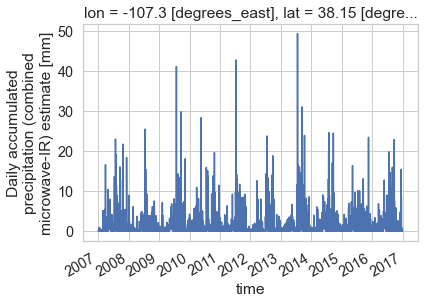

In [9]:
gpm_xr['precipitationCal'][:,20,13].plot()

#### Test the code to match a single co-located Landslide event using nearest neighbor method

In [10]:
test = gpm_xr['precipitationCal'].sel(indexers={'time':glc_co.index[0], 
                  'lon':glc_co.longitude[0],
                  'lat':glc_co.latitude[0]},
                method="nearest")
print(glc_co.index[0], glc_co.longitude[0], glc_co.latitude[0])
test['time'].values, test['lon'].values, test['lat'].values

2007-06-01 00:00:00 -105.8752 40.0929


(numpy.datetime64('2007-06-01T00:00:00.000000000'),
 array(-105.85, dtype=float32),
 array(40.05, dtype=float32))

#### Create the DataFrame of co-located Landslides and precipitation for 7, 14, and 30 days

In [11]:
gpm_7days_df = colocate_to_landslide(glc_co, gpm_xr, periods=7)
gpm_14days_df = colocate_to_landslide(glc_co, gpm_xr, periods=14)
gpm_30days_df = colocate_to_landslide(glc_co, gpm_xr, periods=30)

gpm_7days_df

lon        lat  precipitationCal
landslideID time                                               
6253        2007-06-01 -105.849998  40.049999          0.064783
            2007-05-31 -105.849998  40.049999          0.661531
            2007-05-30 -105.849998  40.049999          0.017648
            2007-05-29 -105.849998  40.049999          5.893072
            2007-05-28 -105.849998  40.049999          0.000000
...                            ...        ...               ...
9660        2007-05-30 -107.349998  38.950008          0.103815
            2007-05-29 -107.349998  38.950008          0.029013
            2007-05-28 -107.349998  38.950008          0.000000
            2007-05-27 -107.349998  38.950008          0.188817
            2007-05-26 -107.349998  38.950008          0.277310

[980 rows x 3 columns]

#### Add a count of 30 days of precipitation measurements for each landslide event. This will help in plotting.

In [12]:
gpm_7days_df = add_count(gpm_7days_df, 7)
gpm_14days_df = add_count(gpm_14days_df, 14)
gpm_30days_df = add_count(gpm_30days_df, 30)
gpm_14days_df

lon        lat  precipitationCal  \
landslideID time                                                  
6253        2007-06-01 -105.849998  40.049999          0.064783   
            2007-05-31 -105.849998  40.049999          0.661531   
            2007-05-30 -105.849998  40.049999          0.017648   
            2007-05-29 -105.849998  40.049999          5.893072   
            2007-05-28 -105.849998  40.049999          0.000000   
...                            ...        ...               ...   
9660        2007-05-23 -107.349998  38.950008          0.487778   
            2007-05-22 -107.349998  38.950008          0.176770   
            2007-05-21 -107.349998  38.950008          0.000000   
            2007-05-20 -107.349998  38.950008          0.000000   
            2007-05-19 -107.349998  38.950008          4.562012   

                        days-to-landslide  
landslideID time                           
6253        2007-06-01                -14  
            2007-05-31                -13  
            2007-05-30                -12  
            2007-05-29                -11  
            2007-05-28                -10  
...                                   ...  
9660        2007-05-23                 -5  
            2007-05-22                 -4  
            2007-05-21                 -3  
            2007-05-20                 -2  
            2007-05-19                 -1  

[1960 rows x 4 columns]

#### Calculated the cumulative precipitation

In [13]:
def cumulative_precip(df):
    """
    Add a column of accumulated precipitation
    
    Parameters
    ----------
    df: pandas.core.frame.DataFrame

    Returns
    -------
    pandas.core.frame.DataFrame plus added column
    """
    
    accum = []
    for i, data in df.groupby("landslideID"):
        accum.extend(data['precipitationCal'].cumsum().values)

    df['precip_accum'] = accum
    return df

In [14]:
gpm_7days_df = cumulative_precip(gpm_7days_df)
gpm_14days_df = cumulative_precip(gpm_14days_df)
gpm_30days_df = cumulative_precip(gpm_30days_df)

gpm_30days_df

lon        lat  precipitationCal  \
landslideID time                                                  
6253        2007-06-01 -105.849998  40.049999          0.064783   
            2007-05-31 -105.849998  40.049999          0.661531   
            2007-05-30 -105.849998  40.049999          0.017648   
            2007-05-29 -105.849998  40.049999          5.893072   
            2007-05-28 -105.849998  40.049999          0.000000   
...                            ...        ...               ...   
9660        2007-05-07 -107.349998  38.950008          0.679384   
            2007-05-06 -107.349998  38.950008          5.879647   
            2007-05-05 -107.349998  38.950008          0.202800   
            2007-05-04 -107.349998  38.950008          2.562155   
            2007-05-03 -107.349998  38.950008          0.317796   

                        days-to-landslide  precip_accum  
landslideID time                                         
6253        2007-06-01                -30      0.064783  
            2007-05-31                -29      0.726314  
            2007-05-30                -28      0.743962  
            2007-05-29                -27      6.637034  
            2007-05-28                -26      6.637034  
...                                   ...           ...  
9660        2007-05-07                 -5     12.167360  
            2007-05-06                 -4     18.047009  
            2007-05-05                 -3     18.249809  
            2007-05-04                 -2     20.811964  
            2007-05-03                 -1     21.129759  

[4200 rows x 5 columns]

#### Plot cumulative precip going back 30 days

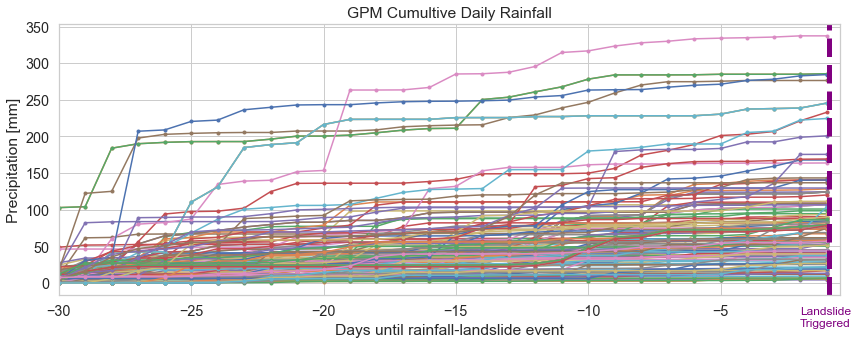

In [20]:
fig, ax = plt.subplots(figsize=(14, 5), sharex=True, sharey=True)

for id, df in gpm_30days_df.groupby("landslideID"):
    ax.plot(df['days-to-landslide'], df['precip_accum'], marker='.')

#ax.invert_xaxis()
ax.axvline(x=-0.9, ymin=0, color='purple', linestyle='dashed', linewidth=5)
ax.set_xlim([-30,-0.5])
ax.set(xlabel='Days until rainfall-landslide event',
       ylabel='Precipitation [mm]',
       title='GPM Cumultive Daily Rainfall')
ax.text(-2,-59, 'Landslide\nTriggered', color='purple', fontsize='large');

#### Plot the 14 day histogram

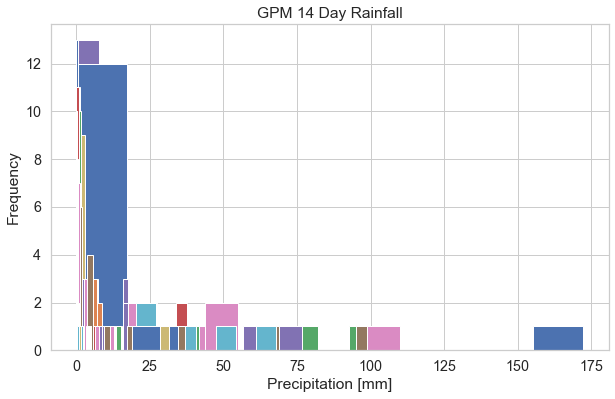

In [21]:
fig, ax = plt.subplots(figsize=(10, 6),sharex=True, sharey=True)

for id, df in gpm_14days_df.groupby("landslideID"):
    ax.hist(df.precipitationCal, histtype='barstacked')

ax.set(ylabel='Frequency',
       xlabel='Precipitation [mm]',
       title='GPM 14 Day Rainfall');